# Transfer Learning with ResNet152
Transfer Learning is a technique where a model trained on one task is re-purposed on a second related task. It is a popular technique in deep learning because it can train deep neural networks with comparatively little data. In this notebook, the ResNet152 model is fine-tuned by unfreezing some of its layers and adding a few dense layers on top that will be retrained on the skin cancer dataset.

In [1]:
import os, shutil
import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import models
from keras import layers
from keras import optimizers
import matplotlib.pyplot as plt

## Load ResNet152 model

In [2]:
# Load the model
conv_base = ResNet152(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))
conv_base.summary()



Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                    

## Load images and labels
First, we load the images and labels from the dataset, which are structured in folders inside the `data` directory. The images are loaded using the `ImageDataGenerator` class from Keras.

In [3]:
# Define directories
base_dir = './data'
train_dir = os.path.join(base_dir, 'train')
train_benign_dir = os.path.join(train_dir, 'benign')
train_malignant_dir = os.path.join(train_dir, 'malignant')
test_dir = os.path.join(base_dir, 'test')
test_benign_dir = os.path.join(test_dir, 'benign')
test_malignant_dir = os.path.join(test_dir, 'malignant')

# Check how many images are in each directory
num_train_images = len(os.listdir(train_benign_dir)) + len(os.listdir(train_malignant_dir))
num_test_images = len(os.listdir(test_benign_dir)) + len(os.listdir(test_malignant_dir))
print('total training images:', num_train_images)
print('total training benign images:', len(os.listdir(train_benign_dir)))
print('total training malignant images:', len(os.listdir(train_malignant_dir)))
print('total test images:', num_test_images)
print('total test benign images:', len(os.listdir(test_benign_dir)))
print('total test malignant images:', len(os.listdir(test_malignant_dir)))

total training images: 2637
total training benign images: 1440
total training malignant images: 1197
total test images: 660
total test benign images: 360
total test malignant images: 300


Benign images:


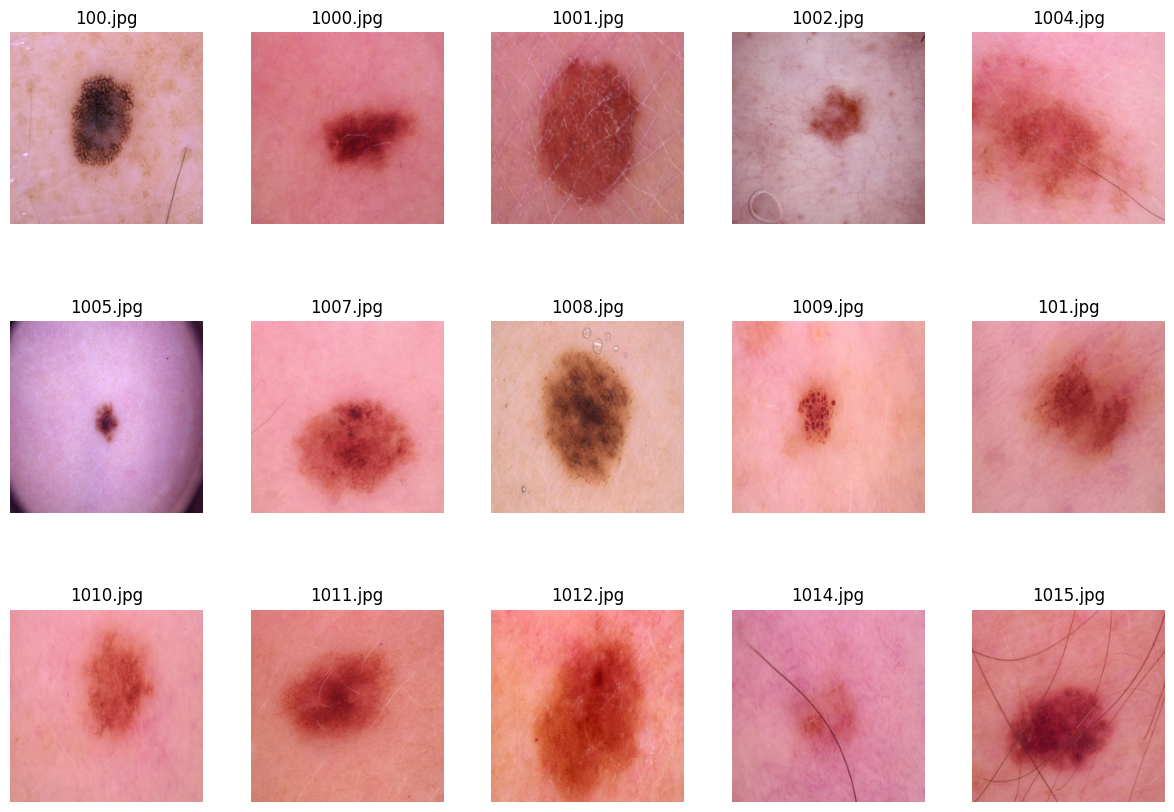

Malignant images:


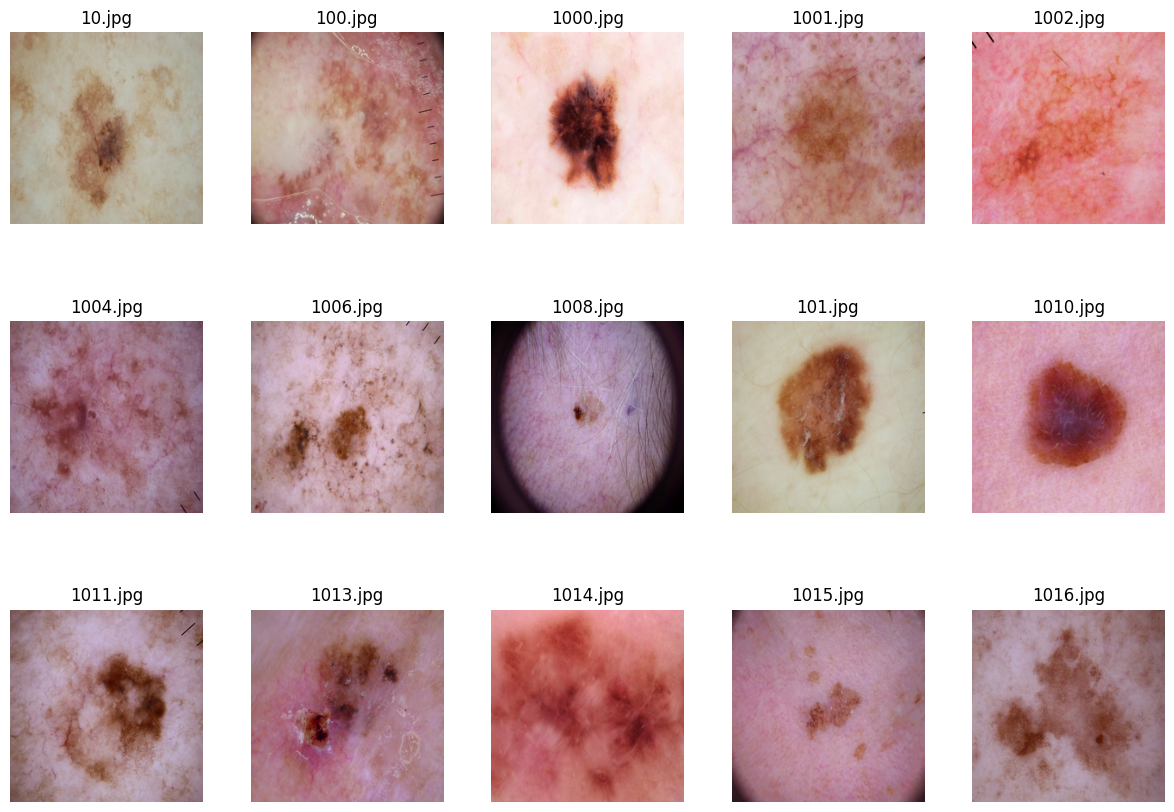

In [4]:
# Show 15 images with their labels
def show_images(directory):
    fig, axes = plt.subplots(3, 5, figsize=(15, 10))
    axes = axes.ravel()
    for i in range(15):
        img = plt.imread(directory + '/' + os.listdir(directory)[i])
        axes[i].imshow(img)
        axes[i].set_title(os.listdir(directory)[i])
        axes[i].axis('off')
    plt.subplots_adjust(hspace=0.5)
    plt.show()

print('Benign images:')
show_images(train_benign_dir)
print('Malignant images:')
show_images(train_malignant_dir)

### Preprocess images
The images are resized to 224x224 pixels and we use the ImageDataGenerator class from Keras to preprocess the images. The images are augmented by rotating, flipping, and zooming them.

In [5]:
# Preprocess the data and perform data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1),
    zoom_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest'
    )

# The validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 64

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


## Define the model
The ResNet152 model is loaded from Keras and the last layers are removed. We add a few dense layers on top of the model that will be retrained on the skin cancer dataset.

In [6]:
## Define the model structure
# Create model
model = models.Sequential()

# Add convolutional base
model.add(conv_base)

# Add new layers
model.add(layers.Flatten()) # Flatten the output of the convolutional base
model.add(layers.Dense(256, activation='relu')) # neurons in the fully connected layer
model.add(layers.Dropout(0.5)) # Dropout layer to prevent overfitting

# Output layer
model.add(layers.Dense(1, activation='sigmoid')) # binary classification

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 84061569 (320.67 MB)
Trainable params: 83910145 (320.09 MB)
Non-trainable params: 151424 (591.50 KB)
_________________________________________________________________


If we were to train the model from scratch, we would need to train it for a long time. Instead, we will use transfer learning to fine-tune the model. We will unfreeze the last few layers of the model and add a few dense layers on top that will be retrained on the skin cancer dataset.

In [7]:
# Unfreeze the last few layers of the convolutional base
# set_trainable = False
# for layer in conv_base.layers:
#     if layer.name == 'conv5_block3_1_conv':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False

## Train the CNN model
We define some callbacks to save the best model and apply early stopping if the validation loss does not improve after a certain number of epochs. We then train the model using the `fit` method.

In [8]:
# Parameters
loss = 'categorical_crossentropy'
metrics = ['accuracy']
learning_rate = 0.0001
optimizer = optimizers.RMSprop(learning_rate=learning_rate)
steps_per_epoch = num_train_images // batch_size
validation_steps = num_test_images // batch_size
epochs = 30

# Model callbacks
model_path = f'models/ResNet152_{learning_rate}_{epochs}.h5'
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True)]

In [9]:
# Compile model
model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)

# Train model
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=test_generator,
                    callbacks=callbacks)

Epoch 1/30



c:\Users\elena\Desktop\ADNE_practicas\ADNE\lib\site-packages\tensorflow\python\util\dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


: 

## Evaluation
We first plot the accuracy and loss of the model during training and validation. We then evaluate the model on the test set and print the classification report.

ValueError: x and y must have same first dimension, but have shapes (1,) and (7,)

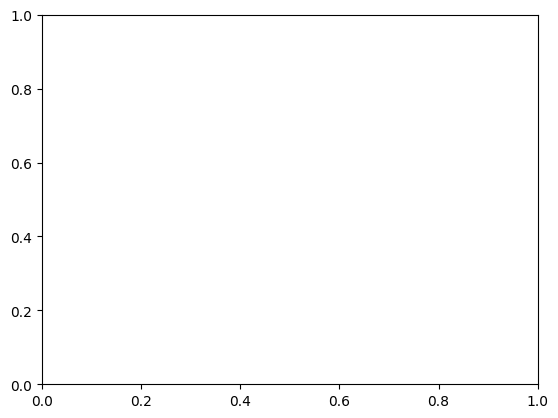

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()